# Import dataset

In [1]:
import pycaret
import pandas as pd
print(pd.__version__)
print(pycaret.__version__)

2.1.4
3.3.2


In [2]:
import pandas as pd
data = pd.read_csv('../data/02_mushroom_species_data.csv')
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,convex,smooth,brown,bruises,pungent,free,close,narrow,black,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,edible,convex,smooth,yellow,bruises,almond,free,close,broad,black,...,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,bruises,anise,free,close,broad,brown,...,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,poisonous,convex,scaly,white,bruises,pungent,free,close,narrow,brown,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,edible,convex,smooth,gray,no,none,free,crowded,broad,black,...,smooth,white,white,partial,white,one,evanescent,brown,abundant,grasses


# Exploratory Data Analysis

In [3]:
data['class'].value_counts()

class
edible       4208
poisonous    3916
Name: count, dtype: int64

Relatively balanced dataset

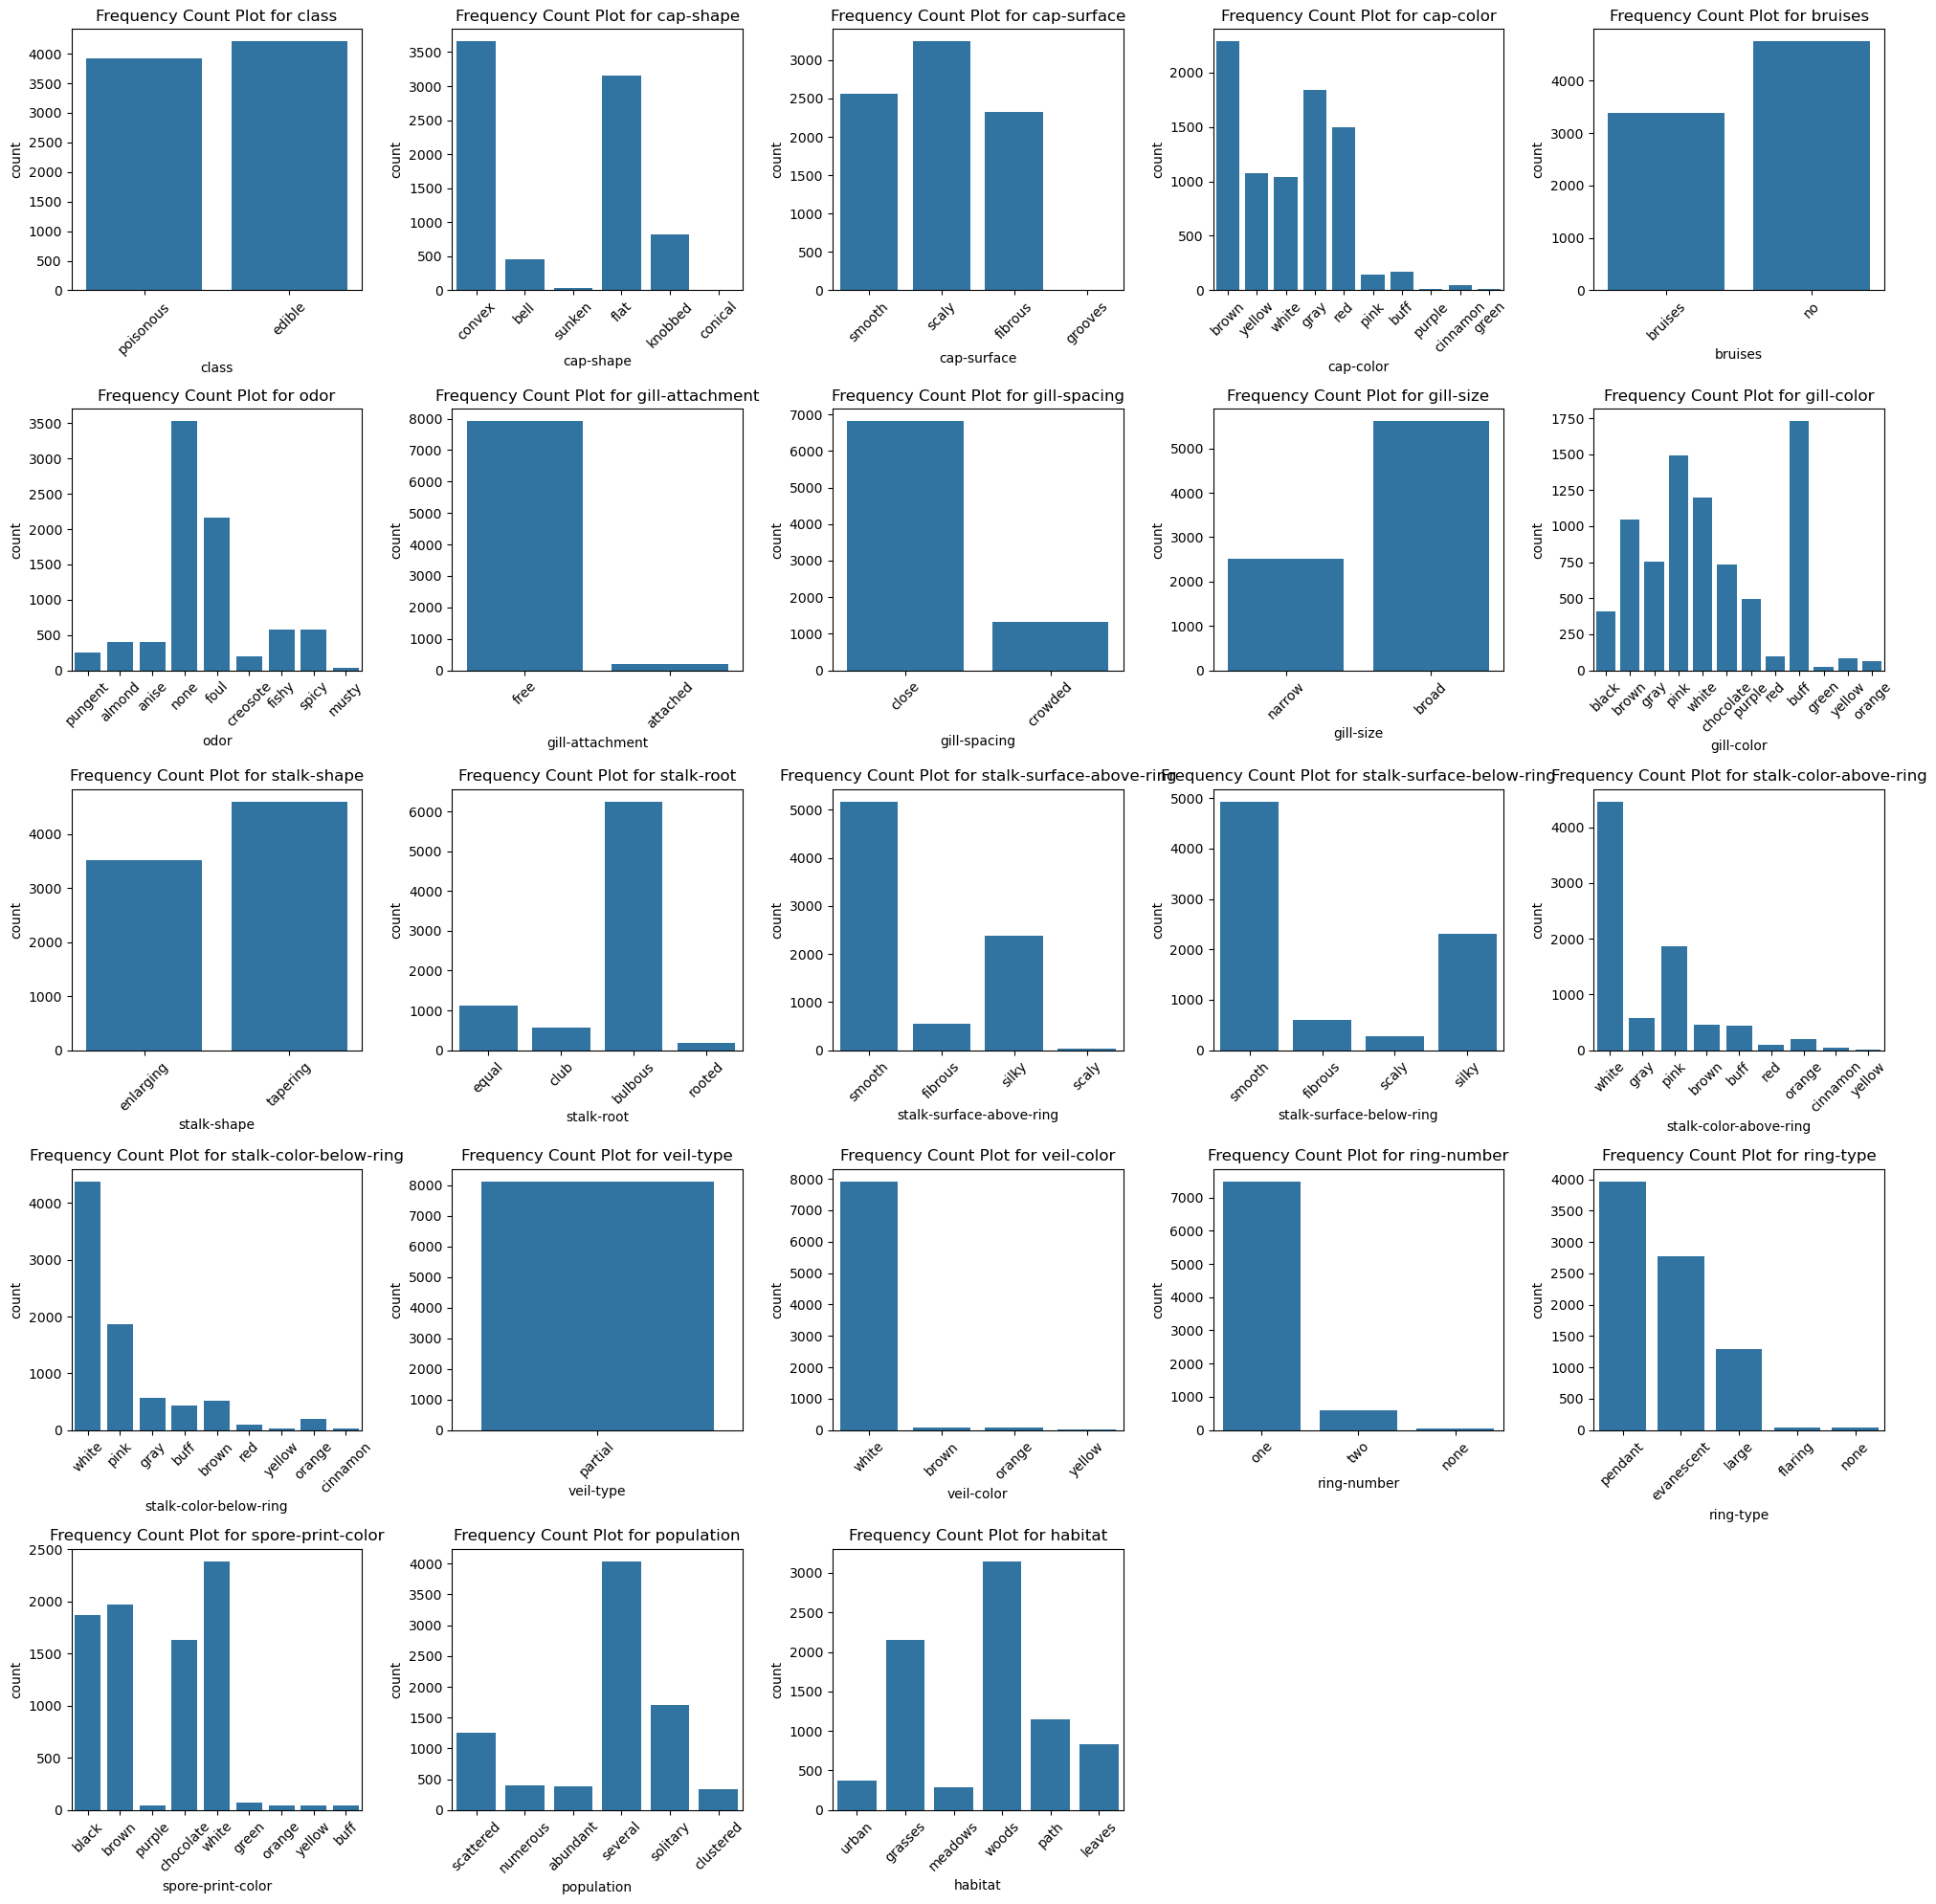

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
fig, axes = plt.subplots(5, 5, figsize=(20, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each categorical column
for i, col in enumerate(data.columns):
    sns.countplot(data=data, x=col, ax=axes[i])
    axes[i].set_title(f'Frequency Count Plot for {col}')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x labels if needed

# Hide any empty subplots (if the total number of columns isn't a multiple of 4)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

From here we can discover these things:

1. unnecessary feature: veil-type
2. column with wrong type: ring-number (should be int instead of string)
3. veil-color and gill-attachment is heavily unbalanced and should be removed
4. columns where values are true or false: gill-attachment (attached or not), bruises (have bruises or not)
5. column with wrong type: ring-number (should be int instead of string)
5. other columns have slight unbalanceness

The other categorical columns should be one-hot encoded.

In [5]:
data.duplicated().sum()

0

No duplicated data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

There are rows with empty habitat values

# Data Preprocessing
With the 3 discoveries I found, I will be processing this outside of pycaret setup as the users inputs when model is deployed would follow the new inputs

For example
- are there bruises: yes or no
- how many rings are there: (numeric answers)

In [7]:
data['bruises'] = data['bruises'].replace({'no':0, 'bruises':1})
data['ring-number'] = data['ring-number'].replace({'one': 1, 'two': 2, 'none': 0})

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   int64 
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

See that there is empty values in habitat

# Setup
excluding features we found that were heavily imbalanced or unnecessary

ignore_list = ['veil-type', 'gill-attachment', 'veil-color']

set categorical_imputation='drop' to remove rows with empty values (in habitat column)

In [8]:
# import pycaret classification and init setup
cat_cols = ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'ring-type', 'spore-print-color', 'population', 'habitat']
num_cols = ['ring-number']
ignore_list = ['veil-type', 'gill-attachment', 'veil-color']

from pycaret.classification import *
setup(data, target = 'class', session_id = 123, 
      ignore_features = ignore_list,
      categorical_features = cat_cols, 
      numeric_features = num_cols, 
      categorical_imputation='drop', # to remove rows with empty values for habitat
     )

,Description,Value
0,Session id,123
1,Target,class
2,Target type,Binary
3,Target mapping,"edible: 0, poisonous: 1"
4,Original data shape,"(8124, 23)"
5,Transformed data shape,"(7932, 100)"
6,Transformed train set shape,"(5554, 100)"
7,Transformed test set shape,"(2378, 100)"
8,Ignore features,3
9,Numeric features,1


see the transformed datashape went down to 7932 rows which is the number of rows where habitat column is not null

In [9]:
get_config('X_train_transformed').head()

,cap-shape_flat,cap-shape_convex,cap-shape_knobbed,cap-shape_bell,cap-shape_sunken,cap-shape_conical,cap-surface_smooth,cap-surface_scaly,cap-surface_fibrous,cap-surface_grooves,...,population_solitary,population_numerous,population_clustered,population_abundant,habitat_grasses,habitat_woods,habitat_path,habitat_meadows,habitat_leaves,habitat_urban
1287,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6411,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4564,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3565,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3892,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# compare baseline mode
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1830
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.2610
qda,Quadratic Discriminant Analysis,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1840
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.2840
et,Extra Trees Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.2590
xgboost,Extreme Gradient Boosting,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.2800
lightgbm,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.2760
lr,Logistic Regression,0.9998,1.0000,0.9998,0.9998,0.9998,0.9996,0.9996,0.9720
dt,Decision Tree Classifier,0.9998,0.9998,0.9998,0.9998,0.9998,0.9996,0.9996,0.1640
svm,SVM - Linear Kernel,0.9998,1.0000,0.9998,0.9998,0.9998,0.9996,0.9996,0.1660


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

## Using the best ensemble model to view feature importance
There are 20 features which is too many for users to input

In [11]:
model = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [12]:
feature_importance = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': get_config('X_test_transformed').columns, 
                                      'Importance': feature_importance}).sort_values(by='Importance', ascending=False)
feature_importance_df.head(20)

,Feature,Importance
21,odor_none,0.092251
32,gill-size,0.087916
22,odor_foul,0.087099
80,ring-type_pendant,0.056094
20,bruises,0.048798
50,stalk-surface-above-ring_silky,0.045045
34,gill-color_buff,0.043596
85,spore-print-color_chocolate,0.041960
31,gill-spacing,0.037029
84,spore-print-color_white,0.025030


From this we can see the top 10 features affecting the output results are:
1. odor
2. gill-size
3. ring-type
4. bruises
5. stalk-surface-above-ring
6. gill-color
7. spore-print-color
8. gill-spacing
9. stalk-root
10. stalk-surface-below-ring


## Testing model with only top 10 features

In [16]:
ignore_list = ['cap-shape', 'cap-surface', 'cap-color', 'gill-attachment', 'stalk-shape', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-color', 'veil-type', 'ring-number', 'population', 'habitat']

from pycaret.classification import *
setup(data, target = 'class', session_id = 123, 
      ignore_features = ignore_list,
      categorical_features = ['odor', 'gill-size', 'ring-type', 'bruises', 'stalk-surface-above-ring', 'gill-color'], 
      categorical_imputation='drop', # to remove columns with empty values for habitat
     )

,Description,Value
0,Session id,123
1,Target,class
2,Target type,Binary
3,Target mapping,"edible: 0, poisonous: 1"
4,Original data shape,"(8124, 23)"
5,Transformed data shape,"(8124, 51)"
6,Transformed train set shape,"(5686, 51)"
7,Transformed test set shape,"(2438, 51)"
8,Ignore features,12
9,Categorical features,10


In [17]:
get_config('X_train').info()

<class 'pandas.core.frame.DataFrame'>
Index: 5686 entries, 1287 to 1947
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   bruises                   5686 non-null   int8    
 1   odor                      5686 non-null   category
 2   gill-spacing              5686 non-null   category
 3   gill-size                 5686 non-null   category
 4   gill-color                5686 non-null   category
 5   stalk-root                5686 non-null   category
 6   stalk-surface-above-ring  5686 non-null   category
 7   stalk-surface-below-ring  5686 non-null   category
 8   ring-type                 5686 non-null   category
 9   spore-print-color         5686 non-null   category
dtypes: category(9), int8(1)
memory usage: 102.1 KB


In [18]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1010
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0870
svm,SVM - Linear Kernel,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0780
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1750
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1760
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.2180
et,Extra Trees Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.2660
xgboost,Extreme Gradient Boosting,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.2340
lightgbm,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1840
catboost,CatBoost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.6380


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

as we can see the performance is still very good, so I will be removing more features

## Using top 7 features

In [19]:
ignore_list_top7 = ignore_list + ['gill-spacing', 'stalk-root', 'stalk-surface-below-ring']

In [21]:
from pycaret.classification import *
setup(data, target = 'class', session_id = 123, 
      ignore_features = ignore_list_top7,
      categorical_features = ['odor', 'gill-size', 'ring-type', 'bruises', 'stalk-surface-above-ring', 'gill-color', 'spore-print-color'], 
      categorical_imputation='drop', # to remove columns with empty values for habitat
     )

,Description,Value
0,Session id,123
1,Target,class
2,Target type,Binary
3,Target mapping,"edible: 0, poisonous: 1"
4,Original data shape,"(8124, 23)"
5,Transformed data shape,"(8124, 42)"
6,Transformed train set shape,"(5686, 42)"
7,Transformed test set shape,"(2438, 42)"
8,Ignore features,15
9,Categorical features,7


In [22]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0790
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0670
svm,SVM - Linear Kernel,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0770
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1540
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1340
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1790
et,Extra Trees Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1450
xgboost,Extreme Gradient Boosting,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1130
lightgbm,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1120
catboost,CatBoost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0290


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

models still had 100% accuracy lets try with top 6 features

## Using Top 6 features

In [23]:
ignore_list_top6 = ignore_list + ['spore-print-color', 'gill-spacing', 'stalk-root', 'stalk-surface-below-ring']

In [27]:
from pycaret.classification import *
setup(data, target = 'class', session_id = 123, 
      ignore_features = ignore_list_top6,
      categorical_features = ['odor', 'gill-size', 'ring-type', 'bruises', 'stalk-surface-above-ring', 'gill-color'], 
      categorical_imputation='drop', # to remove columns with empty values for habitat
     )

,Description,Value
0,Session id,123
1,Target,class
2,Target type,Binary
3,Target mapping,"edible: 0, poisonous: 1"
4,Original data shape,"(8124, 23)"
5,Transformed data shape,"(8124, 33)"
6,Transformed train set shape,"(5686, 33)"
7,Transformed test set shape,"(2438, 33)"
8,Ignore features,16
9,Categorical features,6


In [28]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9968,0.9967,0.9968,0.9969,0.9968,0.9937,0.9937,0.0710
dt,Decision Tree Classifier,0.9968,0.9996,0.9968,0.9969,0.9968,0.9937,0.9937,0.0490
rf,Random Forest Classifier,0.9968,0.9996,0.9968,0.9969,0.9968,0.9937,0.9937,0.1670
et,Extra Trees Classifier,0.9968,0.9996,0.9968,0.9969,0.9968,0.9937,0.9937,0.1410
xgboost,Extreme Gradient Boosting,0.9968,0.9996,0.9968,0.9969,0.9968,0.9937,0.9937,0.1040
lightgbm,Light Gradient Boosting Machine,0.9968,0.9996,0.9968,0.9969,0.9968,0.9937,0.9937,0.1300
catboost,CatBoost Classifier,0.9968,0.9996,0.9968,0.9969,0.9968,0.9937,0.9937,0.9380
gbc,Gradient Boosting Classifier,0.9961,0.9996,0.9961,0.9962,0.9961,0.9922,0.9923,0.1630
svm,SVM - Linear Kernel,0.9954,0.9994,0.9954,0.9955,0.9954,0.9908,0.9909,0.0540
ada,Ada Boost Classifier,0.9951,0.9996,0.9951,0.9951,0.9951,0.9901,0.9902,0.1380


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

Accuracy of 0.9968 is usually very very good model performance. However, as the model was able to achieve 100% accuracy with more features before from a test set of 2438, this showed that the model performance is reduced. 

Additionally, the risk of a wrong prediction is high as predicting a poisonous mushroom as edible would be bad.

Hence, we should aim for model with 100% accuracy and users inputing 7 inputs instead of 6 isn't much of a difference.


# Creating model
Using top 7 features, and KNN model

In [31]:
import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")

from pycaret.classification import *

setup(data, 
      target = 'class', 
      train_size = 0.7,
      session_id = 123, 
      ignore_features = ignore_list_top7,
      categorical_features = ['odor', 'gill-size', 'ring-type', 'bruises', 'stalk-surface-above-ring', 'gill-color', 'spore-print-color'], 
      categorical_imputation='drop', # to remove columns with empty values for habitat
      log_experiment = True, 
      experiment_name = 'mushroom'
     )

,Description,Value
0,Session id,123
1,Target,class
2,Target type,Binary
3,Target mapping,"edible: 0, poisonous: 1"
4,Original data shape,"(8124, 23)"
5,Transformed data shape,"(8124, 42)"
6,Transformed train set shape,"(5686, 42)"
7,Transformed test set shape,"(2438, 42)"
8,Ignore features,15
9,Categorical features,7


2024/08/19 12:07:11 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



In [32]:
get_config('X_train')

,bruises,odor,gill-size,gill-color,stalk-surface-above-ring,ring-type,spore-print-color
1287,0,none,broad,chocolate,fibrous,evanescent,black
6411,0,foul,narrow,buff,silky,evanescent,white
4564,0,foul,broad,gray,silky,large,chocolate
3565,0,foul,broad,pink,silky,large,chocolate
3892,0,foul,broad,gray,silky,large,chocolate
...,...,...,...,...,...,...,...
921,0,none,broad,pink,fibrous,evanescent,brown
100,0,none,broad,pink,fibrous,evanescent,black
923,1,anise,narrow,white,smooth,pendant,purple
42,0,none,narrow,gray,smooth,pendant,black


In [33]:
best = create_model('knn')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


  File "C:\Users\Amber\anaconda3\envs\mlops\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\Amber\anaconda3\envs\mlops\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\Amber\anaconda3\envs\mlops\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Amber\anaconda3\envs\mlops\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
2024/08/19 12:07:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/19 12:07:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run K Neighbors Classifier at: http://127.0.0.1:5000/#/experiments/831693794823680582/runs/2477a121ab5a4a90bf0db10896e5ec25.
2024/08/19 12:07:26 INF

## Analyze Model

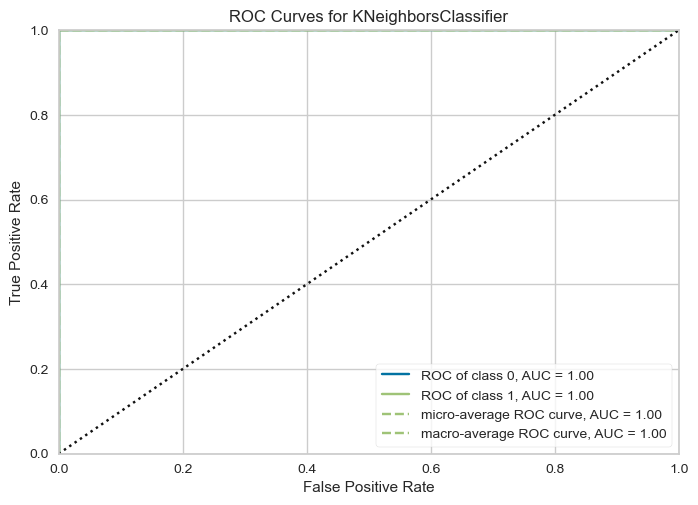

In [34]:
plot_model(best, plot = 'auc')

AUC curve is 1 as my model has a accuracy of 1

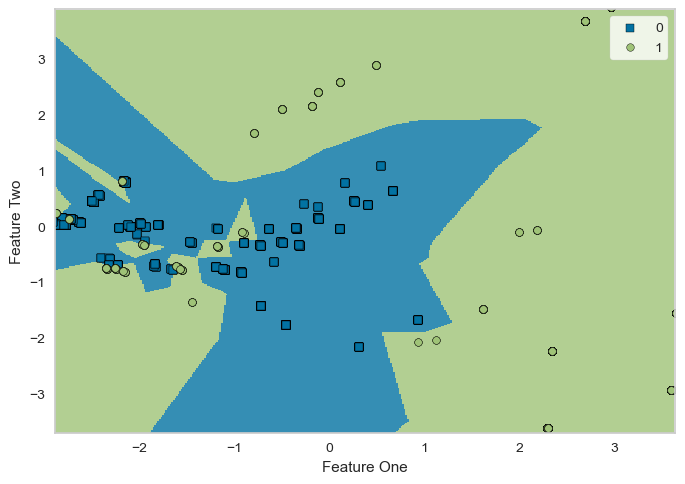

In [35]:
plot_model(best, plot = 'boundary')

From this chart, we can see how KNN separates the feature space into regions where each region corresponds to a different class label. From this we can see that the separation is quite distinct and this contributed to the high accuracy.

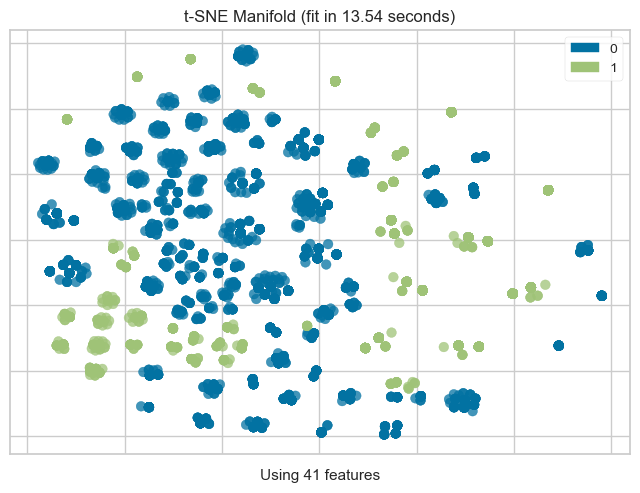

In [36]:
plot_model(best, plot = 'manifold')

From this chart you can see that with just 7 features, the data clusters are well-separated with minimal overlap, that's why the KNN model was able to achieve such accuracy

In [37]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# Predictions

In [38]:
test_combined = pd.concat([get_config('X_test'), get_config('y_test')], axis=1)
test_combined.head()

,bruises,odor,gill-size,gill-color,stalk-surface-above-ring,ring-type,spore-print-color,class
3370,1,none,broad,white,smooth,pendant,black,edible
4466,0,foul,broad,chocolate,silky,large,chocolate,poisonous
4232,1,foul,broad,pink,fibrous,pendant,chocolate,poisonous
5058,1,foul,broad,white,smooth,pendant,chocolate,poisonous
6305,0,foul,narrow,buff,silky,evanescent,white,poisonous


In [39]:
predictions = predict_model(best, data=test_combined)
predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


,bruises,odor,gill-size,gill-color,stalk-surface-above-ring,ring-type,spore-print-color,class,prediction_label,prediction_score
3370,1,none,broad,white,smooth,pendant,black,edible,edible,1.0
4466,0,foul,broad,chocolate,silky,large,chocolate,poisonous,poisonous,1.0
4232,1,foul,broad,pink,fibrous,pendant,chocolate,poisonous,poisonous,1.0
5058,1,foul,broad,white,smooth,pendant,chocolate,poisonous,poisonous,1.0
6305,0,foul,narrow,buff,silky,evanescent,white,poisonous,poisonous,1.0


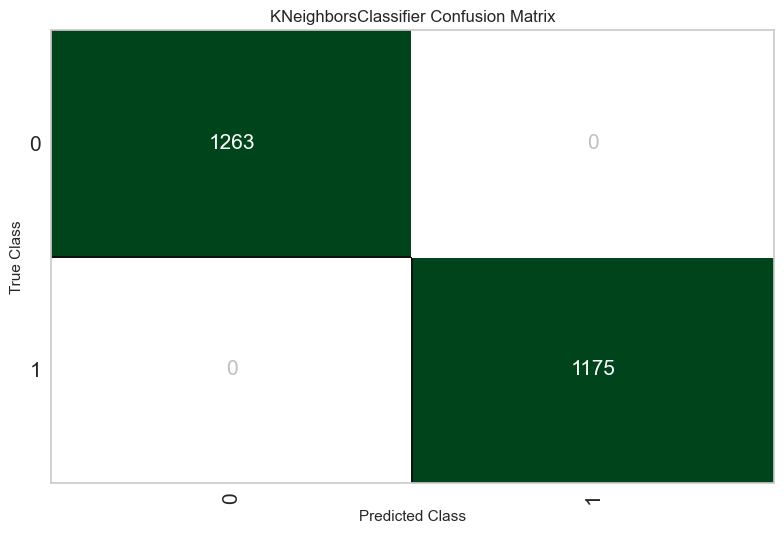

In [40]:
# plot confusion matrix
plot_model(best, plot = 'confusion_matrix')

This is the confusion matrix using the testing data, from this you can see that none of my data was misclassified.

___

## Save Model

In [41]:
# finalize the model
final_best = finalize_model(best)

save_model(final_best, '../models/mushroom-pipeline')

2024/08/19 12:08:24 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/19 12:08:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run K Neighbors Classifier at: http://127.0.0.1:5000/#/experiments/831693794823680582/runs/b1db1c4972d1410ba5bbcfeaebc520ed.
2024/08/19 12:08:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/831693794823680582.


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None, include=[],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('...
                                                               return_df=True,
                                                               use_cat_n

In [42]:
# load pipeline
loaded_best_pipeline = load_model('../models/mushroom-pipeline')
loaded_best_pipeline

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=C:\Users\Amber\AppData\Local\Temp\joblib),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None, include=[],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,...
                                                              return_df=True,
                                                              use_cat_names=True,
                                                              verbose=0))),
                ('clean_column_names',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+'))),
                ('actual_estimator',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=-1, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False)

# Consume model with MLFlow

In [43]:
import mlflow

#Replace with your run id from mlflow localhost website
logged_model = 'runs:/e4dfa1fb99e44ecb8f887c5c3dbfb635/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)